In [ ]:
# Install pyspark
!pip install pyspark
#Install findspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=e92acc3fe16125c7971e0e027f1be5752afb32fe88693b2c091fa18df9abdab0
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Import findspark and initialize.
import findspark
findspark.init()

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import os

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType
from pyspark import SparkFiles
from pyspark.sql.functions import when, lit, col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkFiles

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [ ]:
import requests

url = "https://drive.google.com/uc?id=1t0crmMdDN0AJxopDj7E6UhOs2MMm-okB&export=download"
response = requests.get(url)
with open("/tmp/temp_file.csv", "wb") as f:
    f.write(response.content)

field_df = spark.read.csv("/tmp/temp_file.csv", header=True, inferSchema=True)

# Show DataFrame
field_df.show()

+---+------+--------------------+--------------------+---------------------+-----------------------+---------------+---------------+---------------+------------+
|_c0|UNITID|              INSTNM|             CIPDESC|DEBT_ALL_PP_EVAL_MEAN|DEBT_ALL_STGP_EVAL_MEAN|EARN_MDN_HI_1YR|EARN_MDN_HI_2YR|EARN_NE_MDN_3YR|EARN_MDN_4YR|
+---+------+--------------------+--------------------+---------------------+-----------------------+---------------+---------------+---------------+------------+
| 66|100663|University of Ala...|Communication and...|                34950|                  22131|          28940|          29517|          33859|       40729|
| 89|100663|University of Ala...|Teacher Education...|                34943|                  22612|          30620|          29882|          33214|       38487|
|119|100663|University of Ala...|Liberal Arts and ...|                23949|                  22633|          29046|          30988|          36764|       41150|
|120|100663|University of Al

In [ ]:
# Describe statistical summary
field_df.describe().show()

+-------+------------------+------------------+--------------------+--------------------+---------------------+-----------------------+-----------------+------------------+------------------+------------------+
|summary|               _c0|            UNITID|              INSTNM|             CIPDESC|DEBT_ALL_PP_EVAL_MEAN|DEBT_ALL_STGP_EVAL_MEAN|  EARN_MDN_HI_1YR|   EARN_MDN_HI_2YR|   EARN_NE_MDN_3YR|      EARN_MDN_4YR|
+-------+------------------+------------------+--------------------+--------------------+---------------------+-----------------------+-----------------+------------------+------------------+------------------+
|  count|              9103|              9103|                9103|                9103|                 9103|                   9103|             9103|              9103|              9103|              9103|
|   mean|129979.98165439964|246313.78984950017|                null|                null|    29456.73865758541|      20288.38800395474|37301.65396023289|377

In [ ]:
for column in field_df.columns:
    print(column, ":", field_df.where(col(column).isNull()).count())

_c0 : 0
UNITID : 0
INSTNM : 0
CIPDESC : 0
DEBT_ALL_PP_EVAL_MEAN : 0
DEBT_ALL_STGP_EVAL_MEAN : 0
EARN_MDN_HI_1YR : 0
EARN_MDN_HI_2YR : 0
EARN_NE_MDN_3YR : 0
EARN_MDN_4YR : 0


In [ ]:
# Convert to pandas dataframe for visualizations
field_df_pd = field_df.toPandas()

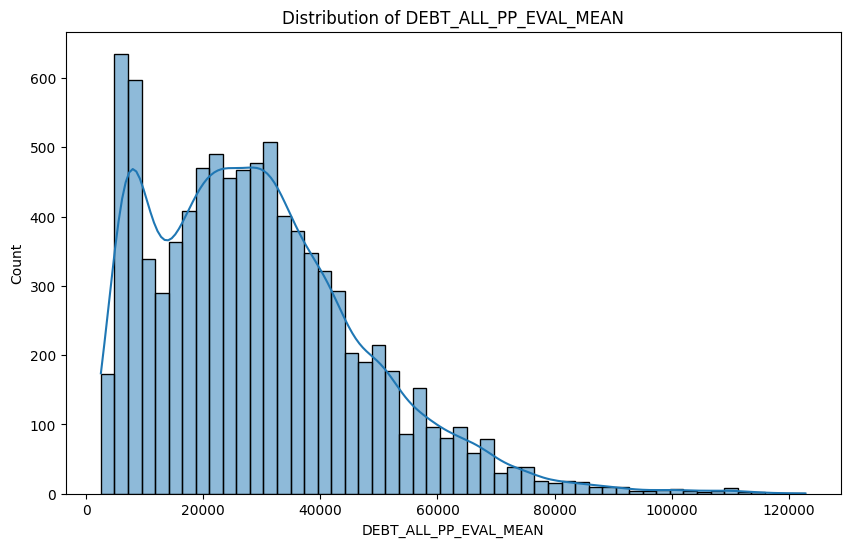

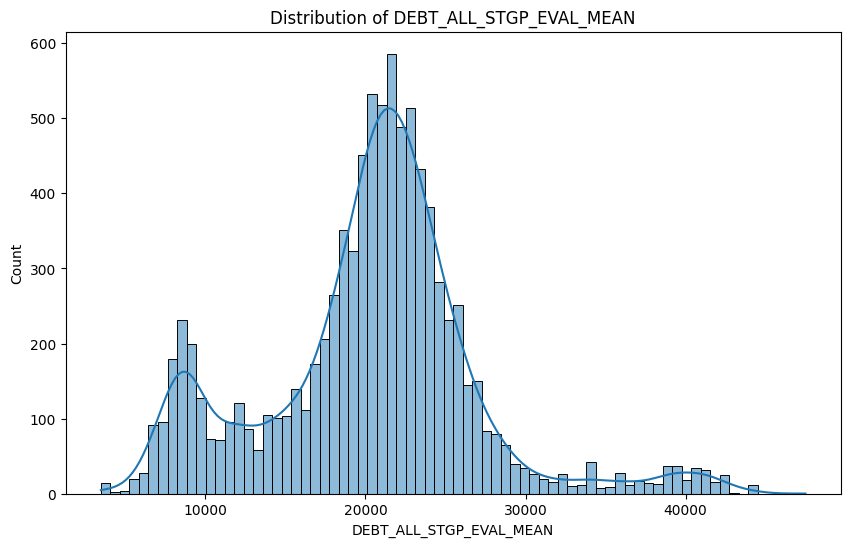

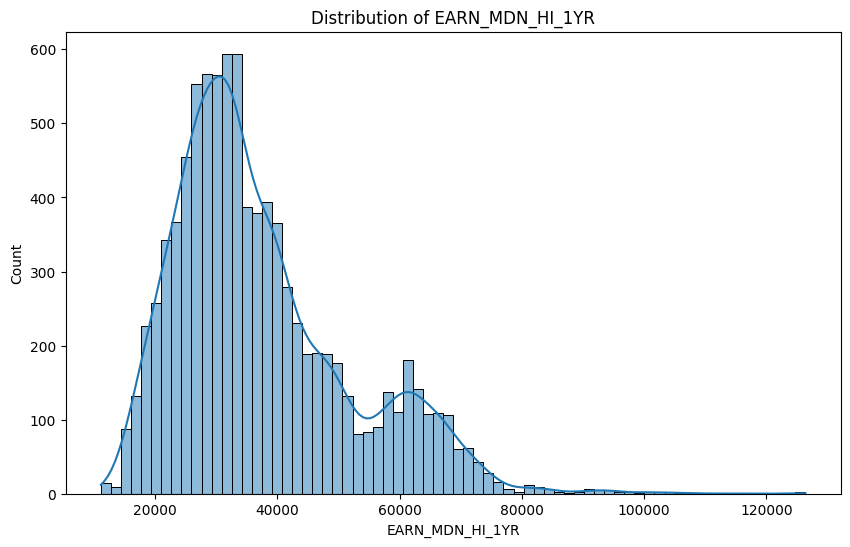

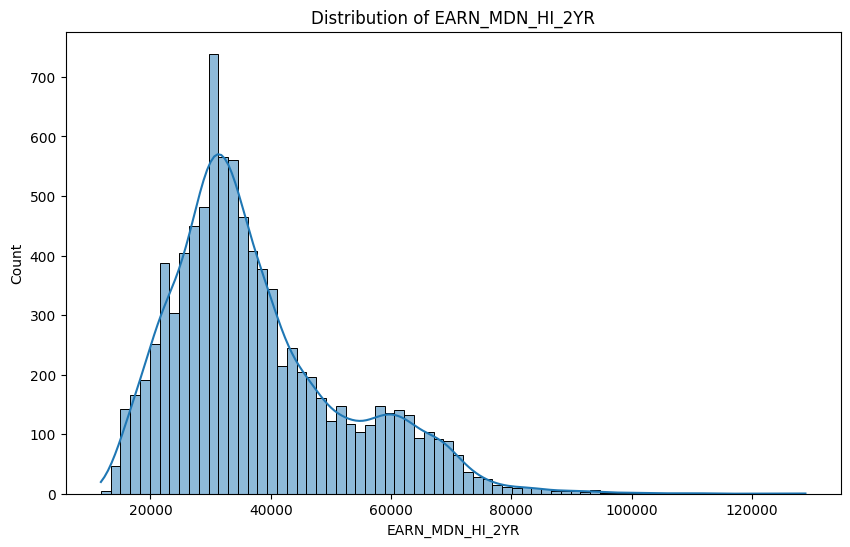

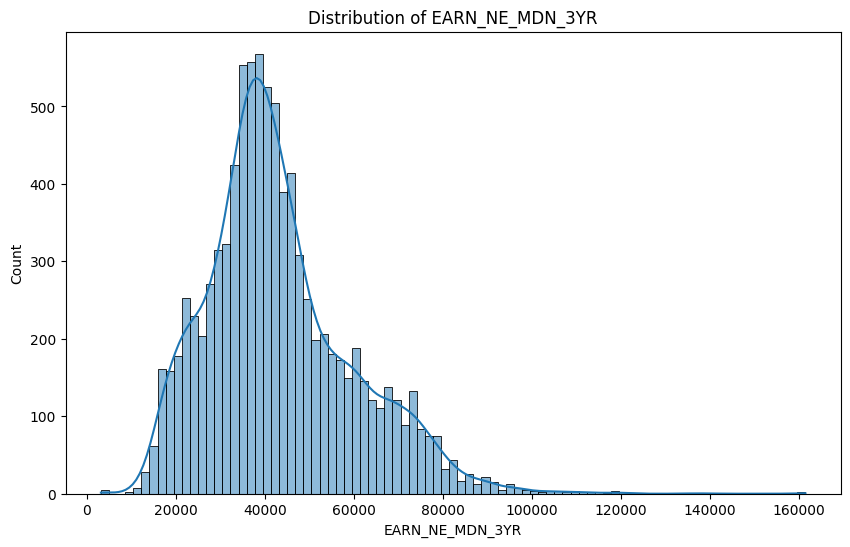

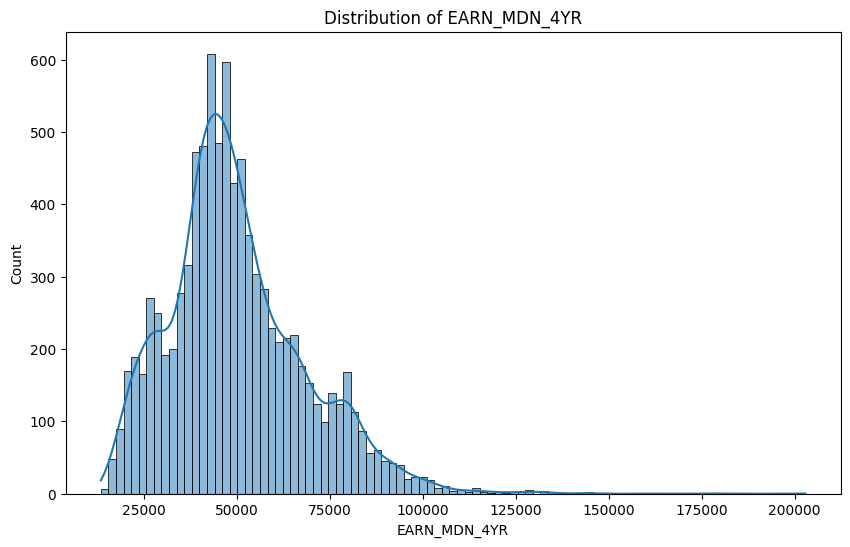

In [ ]:
#Visualize the distribution of relevant data

selected_cols = ["DEBT_ALL_PP_EVAL_MEAN", "DEBT_ALL_STGP_EVAL_MEAN", "EARN_MDN_HI_1YR", "EARN_MDN_HI_2YR", "EARN_NE_MDN_3YR", "EARN_MDN_4YR"]

field_df_pd = field_df.toPandas()

for col in selected_cols:
    plt.figure(figsize=(10,6))
    sns.histplot(field_df_pd[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
# Convert to dense vector for correlation
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
vector_df = assembler.transform(field_df)

In [ ]:
# Convert to dense vector for correlation
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
vector_df = assembler.transform(field_df)

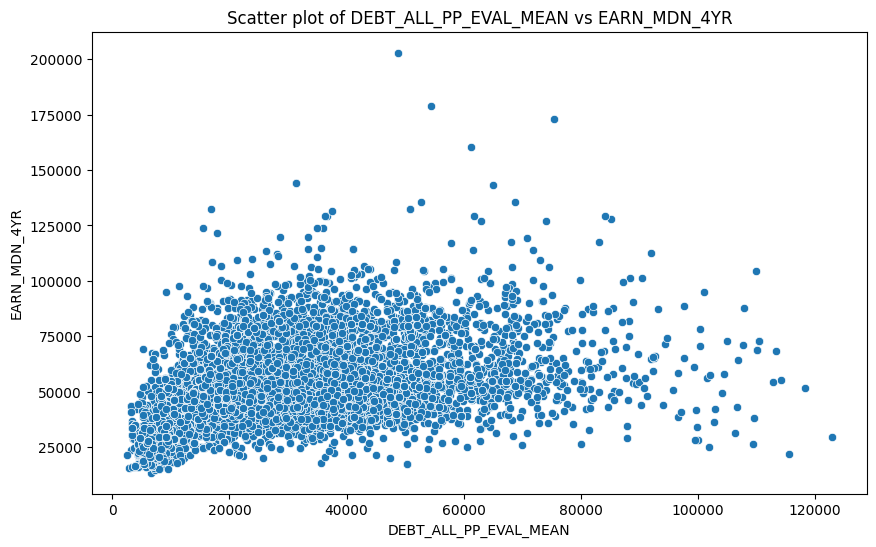

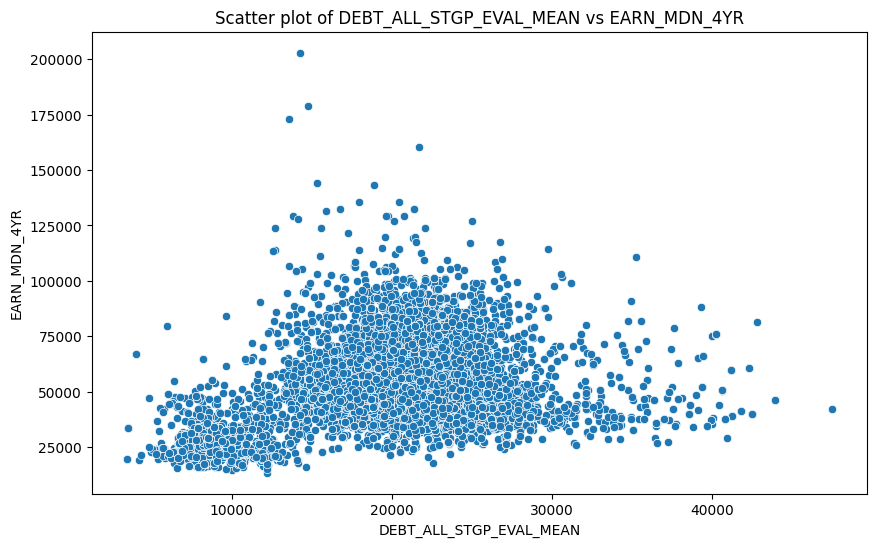

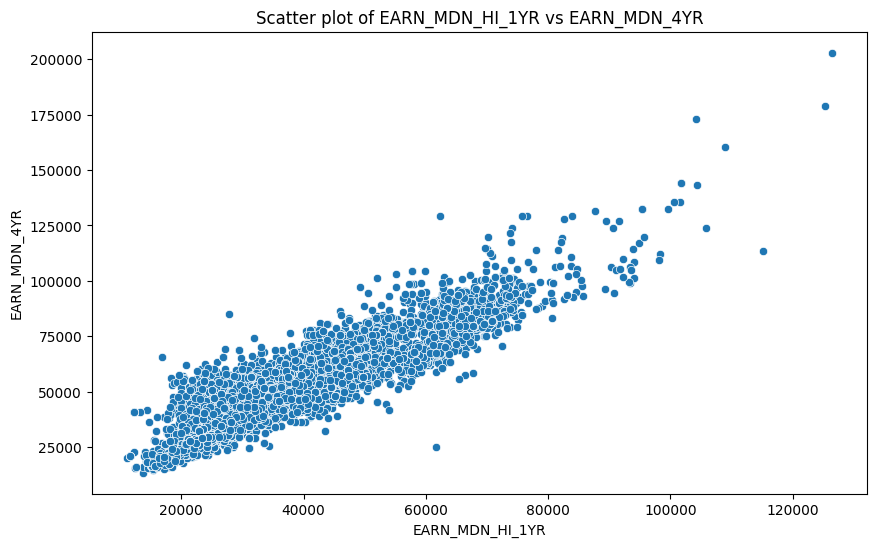

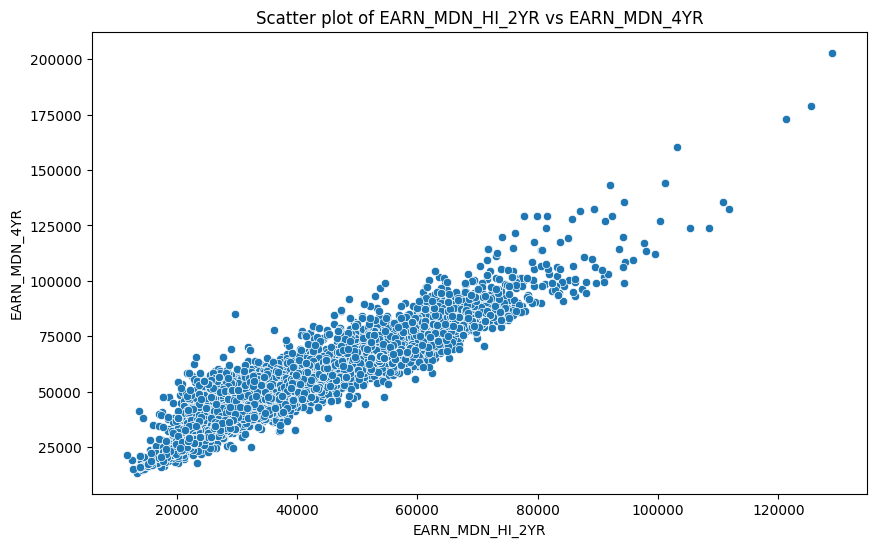

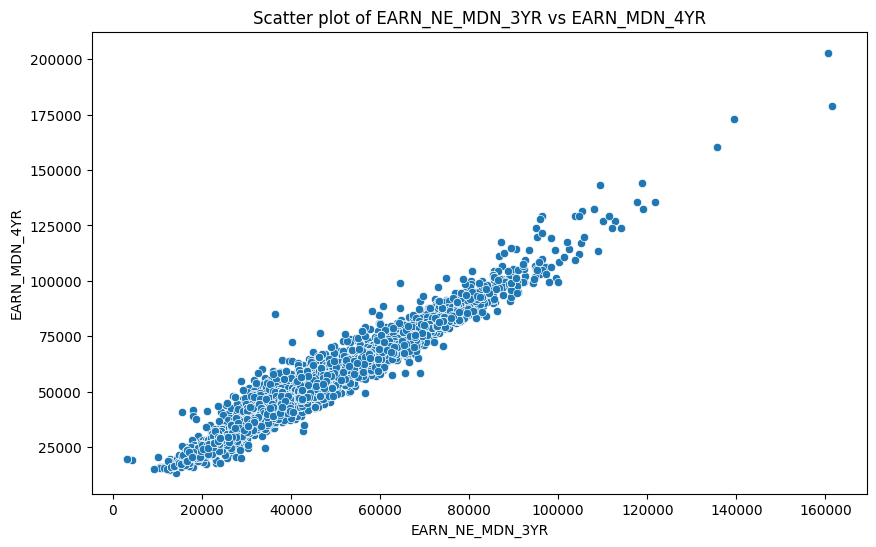

In [ ]:
# Convert to pandas dataframe for visualizations
field_df_pd = field_df.toPandas()

# List of predictor columns
predictor_columns = ["DEBT_ALL_PP_EVAL_MEAN", "DEBT_ALL_STGP_EVAL_MEAN", "EARN_MDN_HI_1YR", "EARN_MDN_HI_2YR", "EARN_NE_MDN_3YR"]

# Create scatter plots
for col in predictor_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=field_df_pd, x=col, y="EARN_MDN_4YR")
    plt.title(f'Scatter plot of {col} vs EARN_MDN_4YR')
    plt.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PolynomialExpansion
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Index the string columns using StringIndexer
indexer1 = StringIndexer(inputCol="CIPDESC", outputCol="CIPDESC_index")
indexer2 = StringIndexer(inputCol="INSTNM", outputCol="INSTNM_index")

# One-hot encode the indexed columns
encoder = OneHotEncoder(inputCols=["CIPDESC_index", "INSTNM_index"],
                        outputCols=["CIPDESC_vec", "INSTNM_vec"])

# Normalization and Scaling
feature_cols = ["DEBT_ALL_PP_EVAL_MEAN", "DEBT_ALL_STGP_EVAL_MEAN", "EARN_MDN_HI_1YR", "EARN_MDN_HI_2YR", "EARN_NE_MDN_3YR"]
assembler_for_scaling = VectorAssembler(inputCols=feature_cols, outputCol="features_for_scaling")
scaler = StandardScaler(inputCol="features_for_scaling", outputCol="scaled_features", withStd=True, withMean=True)

In [ ]:
# Polynomial Features
polyExpansion = PolynomialExpansion(degree=2, inputCol="scaled_features", outputCol="poly_features")

# Create a Debt-to-Earnings Ratio for the 3-year mark
field_df = field_df.withColumn("DEBT_EARN_RATIO_3YR", col("DEBT_ALL_PP_EVAL_MEAN") / col("EARN_NE_MDN_3YR"))

In [ ]:
# Assemble all features together using VectorAssembler
assembler = VectorAssembler(
    inputCols=["CIPDESC_vec", "INSTNM_vec", "DEBT_EARN_RATIO_3YR", "poly_features"],
    outputCol="features"
)

In [ ]:
# Define a pipeline to streamline all transformations
pipeline = Pipeline(stages=[indexer1, indexer2, encoder, assembler_for_scaling, scaler, polyExpansion, assembler])

# Apply the transformations
data_ready = pipeline.fit(field_df).transform(field_df)

In [ ]:
# Split data into train and test sets
train_df, test_df = data_ready.randomSplit([0.8, 0.2], seed=42)

In [57]:
#Run the linear regresstion using PySpark's MLLib
from pyspark.ml.regression import LinearRegression

# Define the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="EARN_MDN_4YR")

# Fit the model
lr_model = lr.fit(train_df)

# Make predictions
predictions_df = lr_model.transform(test_df)

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="EARN_MDN_4YR", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions_df)
print(f"Root Mean Squared Error (RMSE): {mse:.2f}")


Root Mean Squared Error (RMSE): 3276.11


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="EARN_MDN_4YR", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions_df)
print(f"R-squared: {r2}")


R-squared: 0.9674130109933163


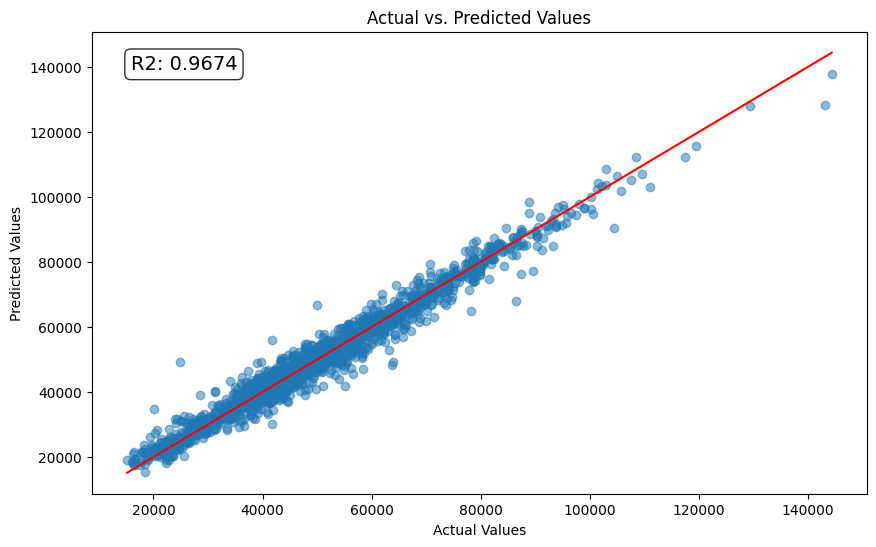

In [ ]:
# Extract actual and predicted values
actual_values = predictions_df.select("EARN_MDN_4YR").rdd.flatMap(lambda x: x).collect()
predicted_values = predictions_df.select("prediction").rdd.flatMap(lambda x: x).collect()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red')
plt.text(0.05, 0.95, f'R2: {r2:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()


In [ ]:
#Define and train RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressor

# Define the regressor
rf_regressor = RandomForestRegressor(featuresCol='features', labelCol='EARN_MDN_4YR', numTrees=100)

# Train the regressor
rf_model = rf_regressor.fit(train_df)

In [ ]:
#Predict on the test data
# Make predictions
predictions_df = rf_model.transform(test_df)

In [ ]:
# Compute RMSE
evaluator_rmse = RegressionEvaluator(labelCol="EARN_MDN_4YR", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions_df)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 4118.75


In [ ]:
#Compute R2 value
evaluator_r2 = RegressionEvaluator(labelCol="EARN_MDN_4YR", predictionCol="prediction", metricName="r2")
fr_r2 = evaluator_r2.evaluate(predictions_df)
print(f"R-squared: {r2}")

R-squared: 0.9674130109933163


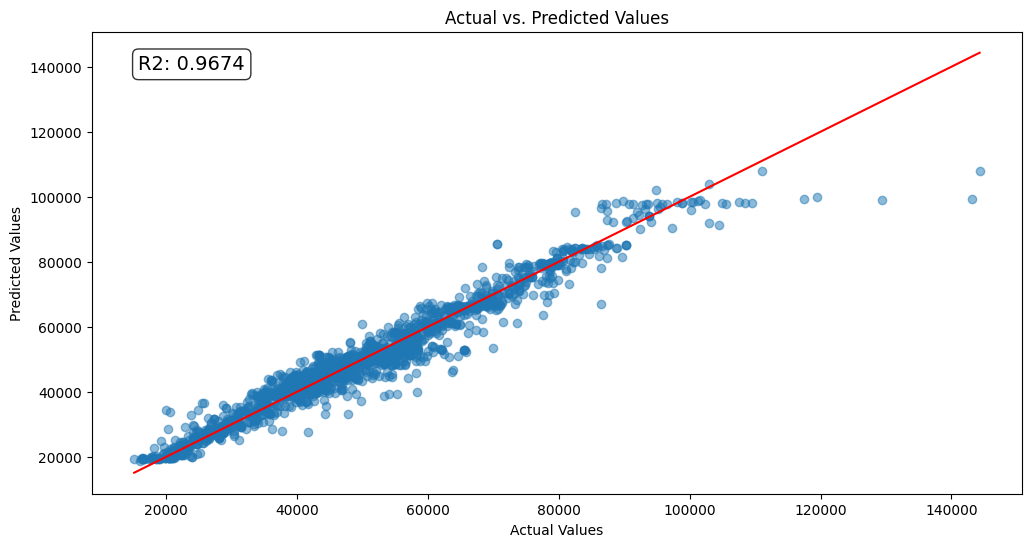

In [ ]:
# Convert to Pandas DataFrame for visualization
pdf = predictions_df.select("EARN_MDN_4YR", "prediction").toPandas()

plt.figure(figsize=(12, 6))
plt.scatter(pdf["EARN_MDN_4YR"], pdf["prediction"], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red')
plt.text(0.05, 0.95, f'R2: {r2:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

In [ ]:
#Optimize the model

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='EARN_MDN_4YR')

In [ ]:
#Define the parameters
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200])  # number of trees
             .addGrid(rf.maxDepth, [10, 20])  # maximum depth
             .addGrid(rf.maxBins, [32, 64])  # Number of bins for discretizing continuous features
             .build())

In [ ]:
#Define the evaluation metric

evaluator = RegressionEvaluator(labelCol="EARN_MDN_4YR", predictionCol="prediction", metricName="rmse")

In [ ]:
#setup crossvalidator
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [56]:
#Run the crossvalidator and find the best model
cvModel = crossval.fit(train_df)
best_rf_model = cvModel.bestModel

#Print the optimal parameters:
print(f"Best number of trees: {best_rf_model.getNumTrees}")
print(f"Best max depth: {best_rf_model.getOrDefault('maxDepth')}")
print(f"Best max bins: {best_rf_model.getOrDefault('maxBins')}")

Best number of trees: 200
Best max depth: 20
Best max bins: 64


In [58]:
predictions = best_rf_model.transform(test_df)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.2f}")

Root Mean Squared Error (RMSE) on test data: 3111.37


In [59]:
from pyspark.ml.evaluation import RegressionEvaluator

# Use the best model to make predictions on the test data
predictions = best_rf_model.transform(test_df)

# Evaluate the model using R-squared metric
r2_evaluator = RegressionEvaluator(labelCol="EARN_MDN_4YR", predictionCol="prediction", metricName="r2")
r2_value = r2_evaluator.evaluate(predictions)

print(f"R-squared on test data = {r2_value:.2f}")

R-squared on test data = 0.97


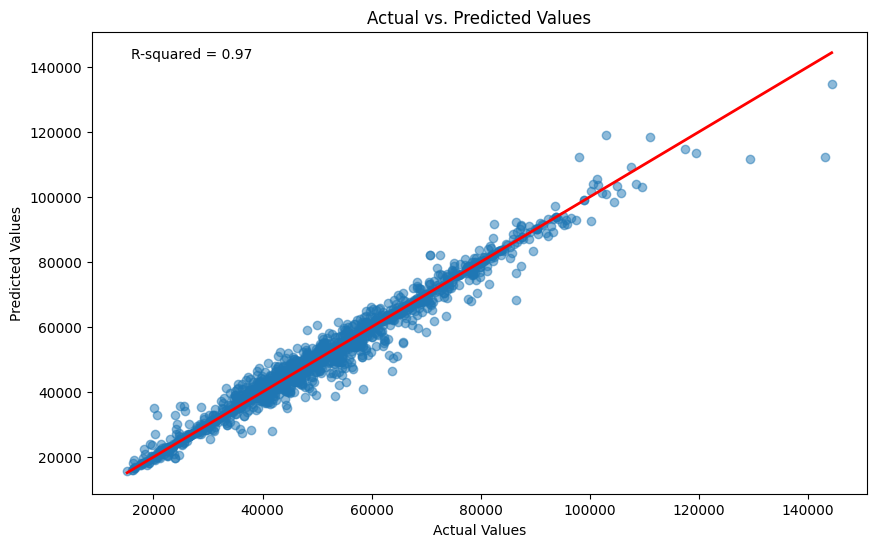

In [60]:
actual = predictions.select("EARN_MDN_4YR").toPandas()
predicted = predictions.select("prediction").toPandas()


plt.figure(figsize=(10, 6))

# Scatter plot of actual vs. predicted
plt.scatter(actual, predicted, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Plot the line for perfect predictions
plt.plot([min(actual["EARN_MDN_4YR"]), max(actual["EARN_MDN_4YR"])],
         [min(actual["EARN_MDN_4YR"]), max(actual["EARN_MDN_4YR"])],
         color="red", linewidth=2)

# Display R-squared value on the plot
plt.text(0.05, 0.95, f'R-squared = {r2_value:.2f}', ha='left', va='center', transform=plt.gca().transAxes)

plt.show()